# Tutorial 03 - Deep Unfolding with a regression model

In [1]:
import uproot
import numpy
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Make sure to install the needed packages:
```
conda install -c anaconda keras
conda install tensorflow
```

In [2]:
f_train = uproot.open( "/Users/jdb/bnl/work/MLatSTAR/train.root" )

In [3]:
f_train.allkeys()

[b'fPtRes;1',
 b'fCrystalBall;1',
 b'fMultEff;1',
 b'fVzEff;1',
 b'fZDC;1',
 b'mult;2',
 b'mult;1',
 b'hmc_Pt;1',
 b'hmc_Eta;1',
 b'hmc_Mult;1',
 b'hrc_Pt;1',
 b'hrc_Eta;1',
 b'hrc_Mult;1',
 b'hMult;1',
 b'hMultTof;1',
 b'hMultBEMC;1']

In [4]:
tree = f_train[b'mult']

In [5]:
tree.show()

reco_mult                  (no streamer)              asdtype('>f4')
tof_mult                   (no streamer)              asdtype('>f4')
bemc_mult                  (no streamer)              asdtype('>f4')
vz                         (no streamer)              asdtype('>f4')
zdcx                       (no streamer)              asdtype('>f4')
mult                       (no streamer)              asdtype('>f4')


In [6]:
arrays = tree.arrays( ["mult", "reco_mult", "tof_mult", "bemc_mult", "vz", "zdcx"] )

In [7]:
arrays

{b'mult': array([325.,   1., 173., ...,  58.,  73.,  45.], dtype=float32),
 b'reco_mult': array([31.,  1., 44., ..., 17., 30., 21.], dtype=float32),
 b'tof_mult': array([108.,   1.,  39., ...,  16.,  22.,  18.], dtype=float32),
 b'bemc_mult': array([5., 0., 3., ..., 0., 1., 0.], dtype=float32),
 b'vz': array([ 34.962646 ,  26.977768 ,  43.881706 , ..., -62.19352  ,
        -59.450607 ,   2.9815679], dtype=float32),
 b'zdcx': array([44887., 49857., 56948., ..., 62706., 68823., 64753.], dtype=float32)}

In [8]:
import matplotlib.pyplot as plt
fs = ( 32, 18 ) # lets make all our figures 16 by 9

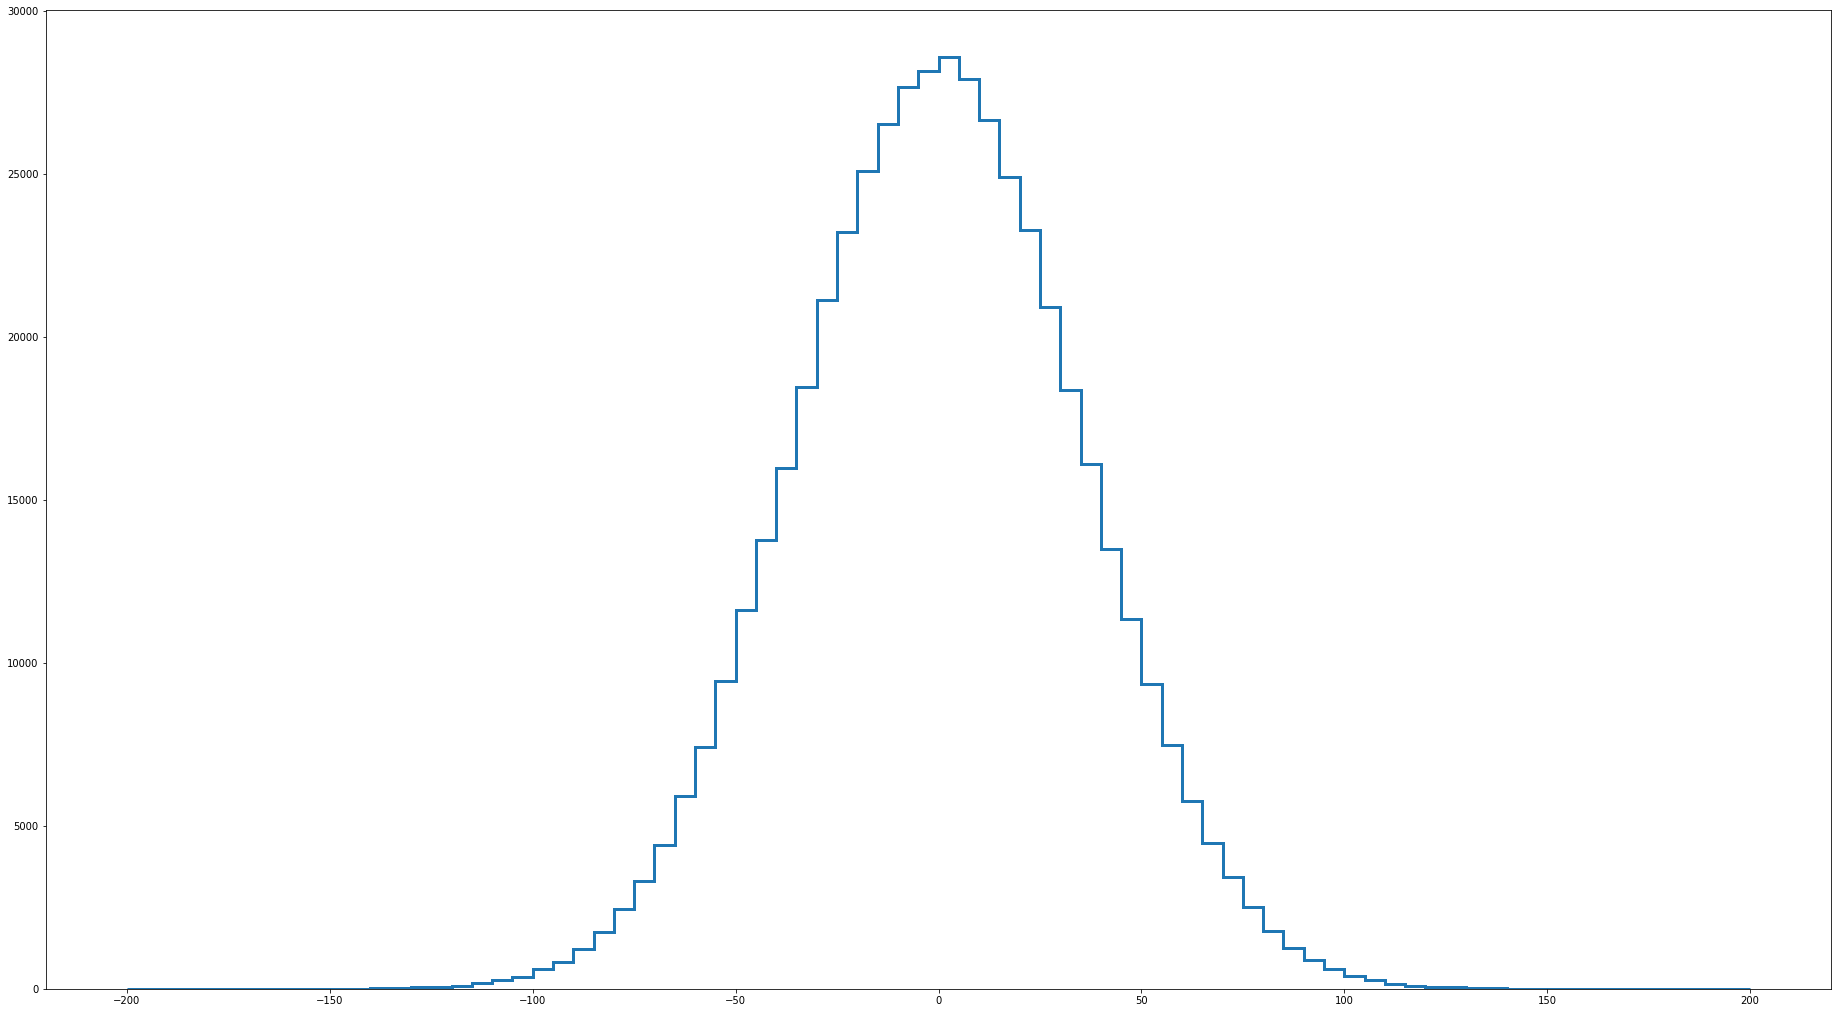

In [9]:
plt.figure(figsize=fs)
plt.hist( arrays[b"vz"].flatten(), bins=range(-200, 205, 5), fill=False, histtype='step', linewidth=3 );

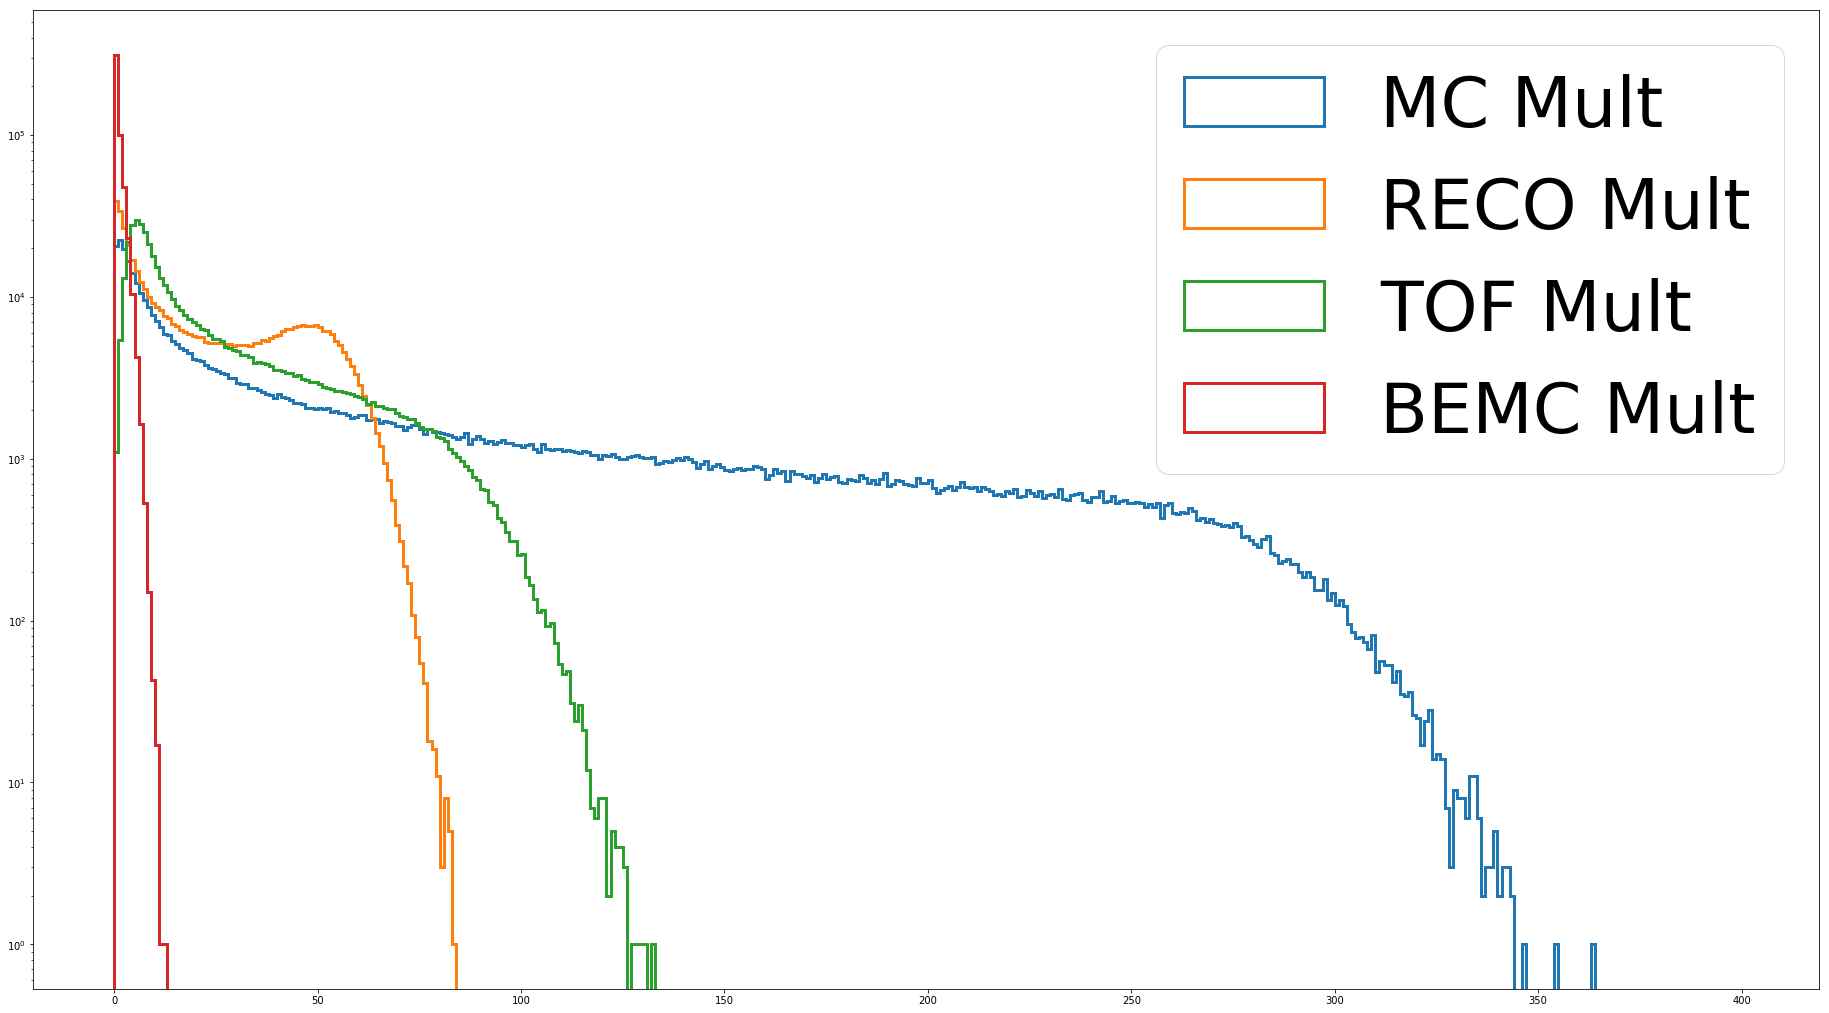

In [10]:
plt.figure(figsize=fs)
plt.hist( arrays[b"mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="MC Mult", linewidth=3 );
plt.hist( arrays[b"reco_mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="RECO Mult", linewidth=3 );
plt.hist( arrays[b"tof_mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="TOF Mult", linewidth=3 );
plt.hist( arrays[b"bemc_mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="BEMC Mult", linewidth=3 );
plt.yscale('log')
plt.gca().legend(prop={'size': 70})

## Train a model with Keras

In [11]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor


In [12]:
def build_model() :
    model = Sequential()
    model.add(Dense(12, input_dim=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()
    return model

In [13]:
model = build_model()

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


## Get our data into the right shape

In [60]:
n_events = 5000
# len( arrays[b"mult"] )
X_train = numpy.empty( shape=(5, n_events) )

In [61]:
X_train[0] = arrays[b"reco_mult"][:n_events]
X_train[1] = arrays[b"tof_mult"][:n_events]
X_train[2] = arrays[b"bemc_mult"][:n_events]
X_train[3] = arrays[b"vz"][:n_events]
X_train[4] = arrays[b"zdcx"][:n_events]

# X_train = numpy.hstack( (numpy.transpose(arrays[b"reco_mult"]), numpy.transpose(arrays[b"tof_mult"])) )

In [62]:
X_train = numpy.transpose(X_train)
X_train

array([[ 3.10000000e+01,  1.08000000e+02,  5.00000000e+00,
         3.49626465e+01,  4.48870000e+04],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         2.69777679e+01,  4.98570000e+04],
       [ 4.40000000e+01,  3.90000000e+01,  3.00000000e+00,
         4.38817062e+01,  5.69480000e+04],
       ...,
       [ 5.40000000e+01,  6.10000000e+01,  2.00000000e+00,
         2.03196449e+01,  4.97990000e+04],
       [ 9.00000000e+00,  1.00000000e+01,  0.00000000e+00,
         9.71580696e+00,  4.53470000e+04],
       [ 3.00000000e+00,  6.00000000e+00,  0.00000000e+00,
        -5.55137205e+00,  5.09140000e+04]])

In [63]:
Y_train = numpy.transpose( arrays[b"mult"][:n_events] )

In [80]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=5,  verbose=1, validation_split=0.5)

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 9s 343us/sample - loss: 395.3988 - mean_squared_error: 395.3988 - mean_absolute_error: 14.6246 - val_loss: 302.4817 - val_mean_squared_error: 302.4817 - val_mean_absolute_error: 11.7084
Epoch 2/50
25000/25000 [==============================] - 9s 342us/sample - loss: 388.0895 - mean_squared_error: 388.0898 - mean_absolute_error: 14.3652 - val_loss: 308.4284 - val_mean_squared_error: 308.4290 - val_mean_absolute_error: 11.8818
Epoch 3/50
25000/25000 [==============================] - 9s 341us/sample - loss: 387.1303 - mean_squared_error: 387.1304 - mean_absolute_error: 14.3445 - val_loss: 328.1391 - val_mean_squared_error: 328.1388 - val_mean_absolute_error: 12.9097
Epoch 4/50
25000/25000 [==============================] - 9s 355us/sample - loss: 382.5953 - mean_squared_error: 382.5956 - mean_absolute_error: 14.1841 - val_loss: 320.1368 - val_mean_squared_error: 320.1370 - val_mea

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


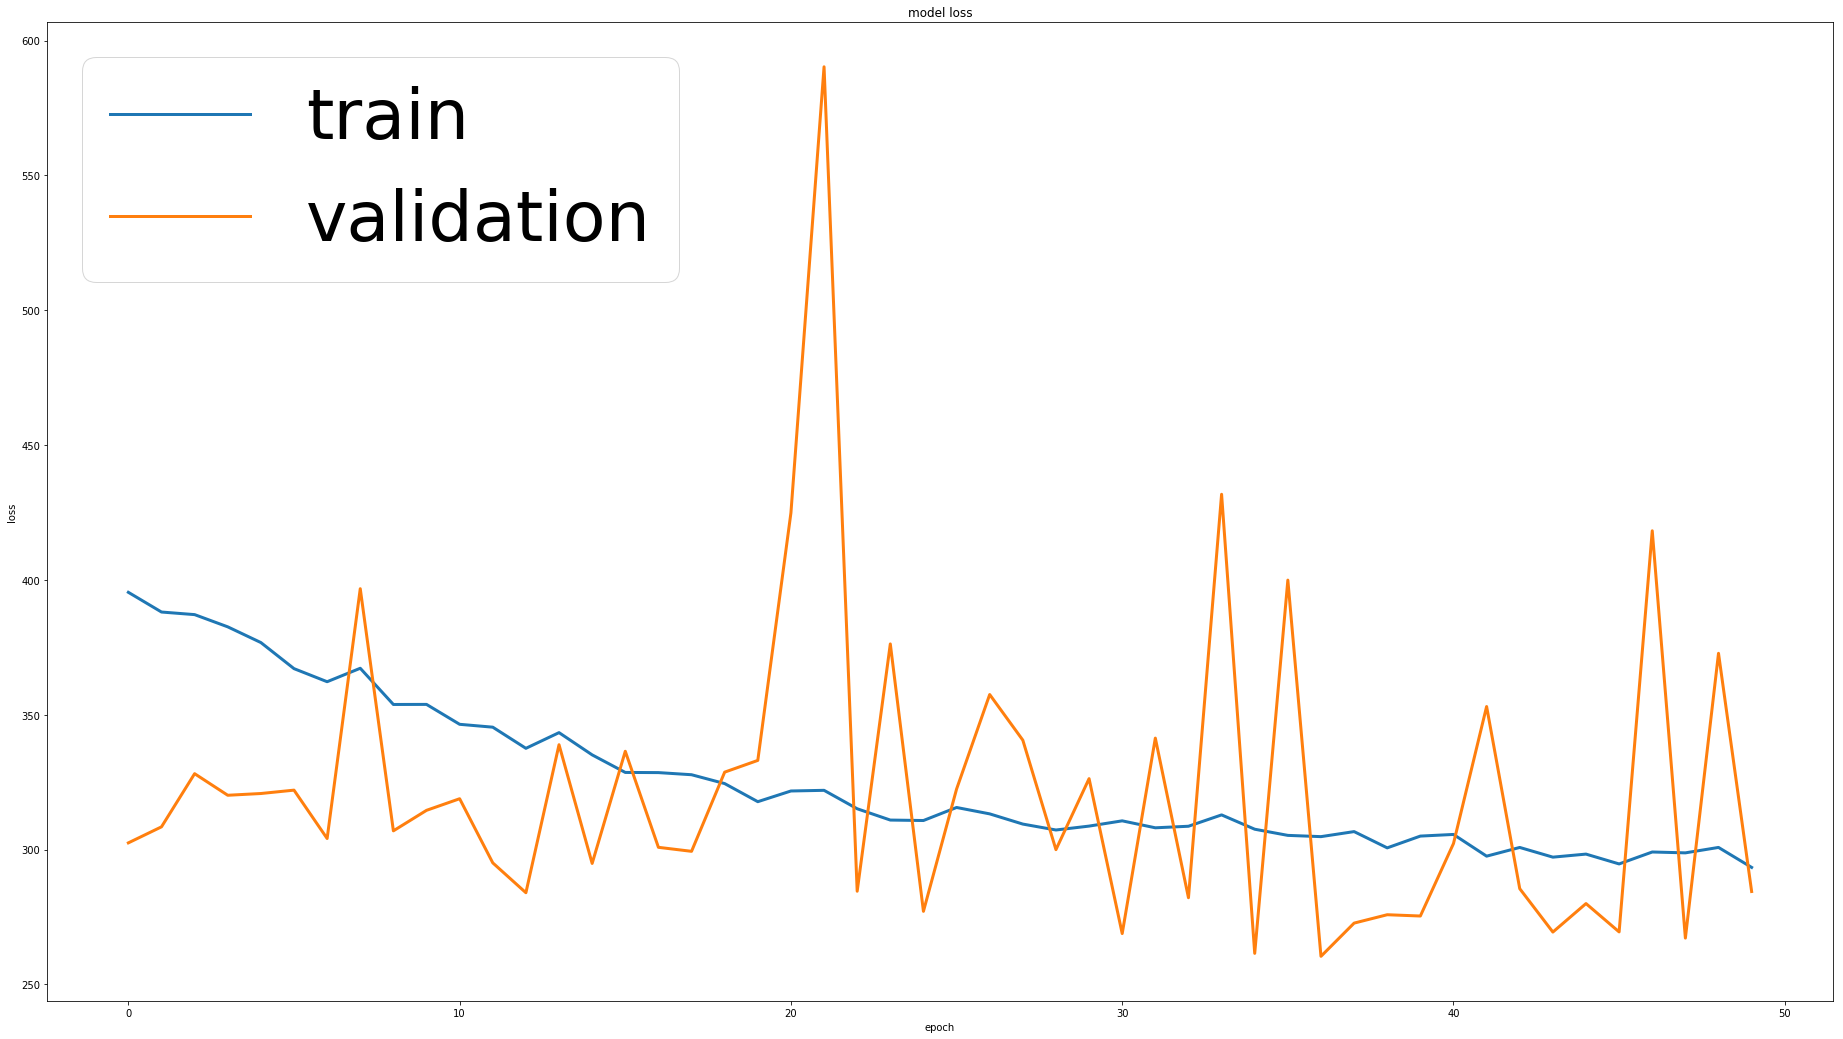

In [81]:
plt.figure(figsize=fs)
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'], linewidth=3)
plt.plot(history.history['val_loss'], linewidth=3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left', prop={'size': 70})
# plt.gca().set_ylim((8000, 11000))
plt.show()

In [74]:
f_test = uproot.open( "/Users/jdb/bnl/work/MLatSTAR/test.root" )

In [75]:
tarrays = f_test["mult"].arrays(["mult", "reco_mult", "tof_mult", "bemc_mult", "vz", "zdcx"])

In [76]:
n_events_test = len( tarrays[b"mult"] )
X_test = numpy.empty( shape=(5, n_events_test) )
X_test[0] = tarrays[b"reco_mult"][:n_events_test]
X_test[1] = tarrays[b"tof_mult"][:n_events_test]
X_test[2] = tarrays[b"bemc_mult"][:n_events_test]
X_test[3] = tarrays[b"vz"][:n_events_test]
X_test[4] = tarrays[b"zdcx"][:n_events_test]
X_test = numpy.transpose( X_test )

In [77]:
Y_test = numpy.transpose( tarrays[b"mult"] )

In [82]:
Y_pred = model.predict(X_test)

## Test the model by comparing it t

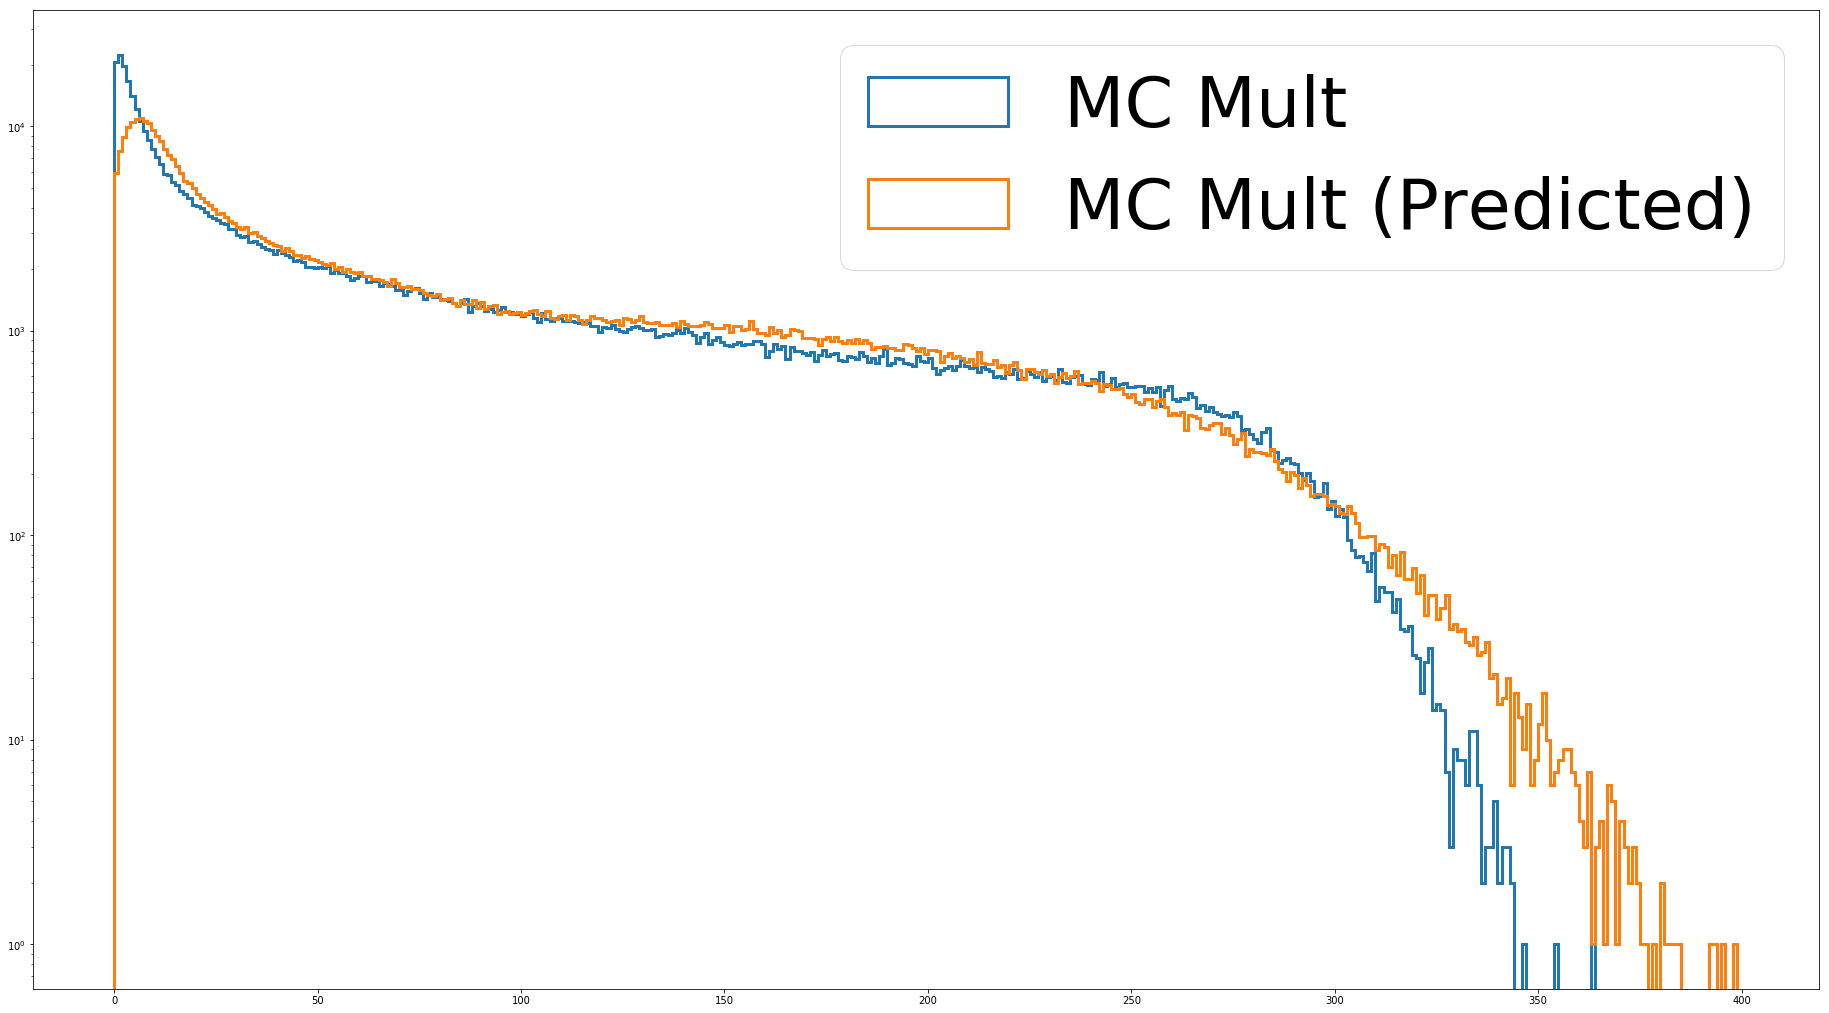

In [83]:

plt.figure(figsize=fs)
plt.hist( Y_test, bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="MC Mult", linewidth=3 )
plt.hist( Y_pred, bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="MC Mult (Predicted)", linewidth=3 )
plt.yscale('log')
plt.gca().legend(prop={'size': 70})